### Preprocessing

In [372]:
# import relevant statistical packages
import numpy as np
import pandas as pd

In [373]:
# import relevant data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [374]:
# import custom packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_linear_regression as PLS
from sklearn.preprocessing import scale

In [375]:
# import data
from sklearn.datasets import load_boston
Boston_data = load_boston()

In [376]:
Boston = pd.DataFrame(Boston_data.data)
Boston.columns = Boston_data.feature_names
Boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [377]:
Boston = pd.get_dummies(Boston, columns =['CHAS'], drop_first=True)

In [378]:
Boston.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1.0
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,0
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,0


In [379]:
Boston.shape

(506, 13)

### 9.a. Fitting a cubic polynomial regression to predict 'nox' using 'dis'

In [380]:
X = Boston['DIS']
y = Boston['NOX']

In [381]:
from sklearn.model_selection import KFold as KF, cross_val_score as CVS
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [382]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

lm = LinearRegression()
MSEdf= pd.DataFrame()
Xi = pd.DataFrame()

# calculating MSE with only the intercept through cross-validation
mse = -1*CVS(lm, np.ones((n,1)), y, cv=kf10, scoring='neg_mean_squared_error').mean()    
MSEdf = MSEdf.append([round(mse, 9)], ignore_index=True)

# calculating MSE for 15 degrees through cross-validation
for i in np.arange(1, 15):
    Xi = pd.concat([Xi, X**i], axis = 1)
    mse = -1*CVS(lm, Xi.iloc[:,:i], y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf

,MSE
0,0.013428
1,0.005508
2,0.004070
3,0.003849
4,0.003872
5,0.004146
6,0.005895
7,0.011533
8,0.004486
9,0.004798


Text(0,0.5,'MSE')

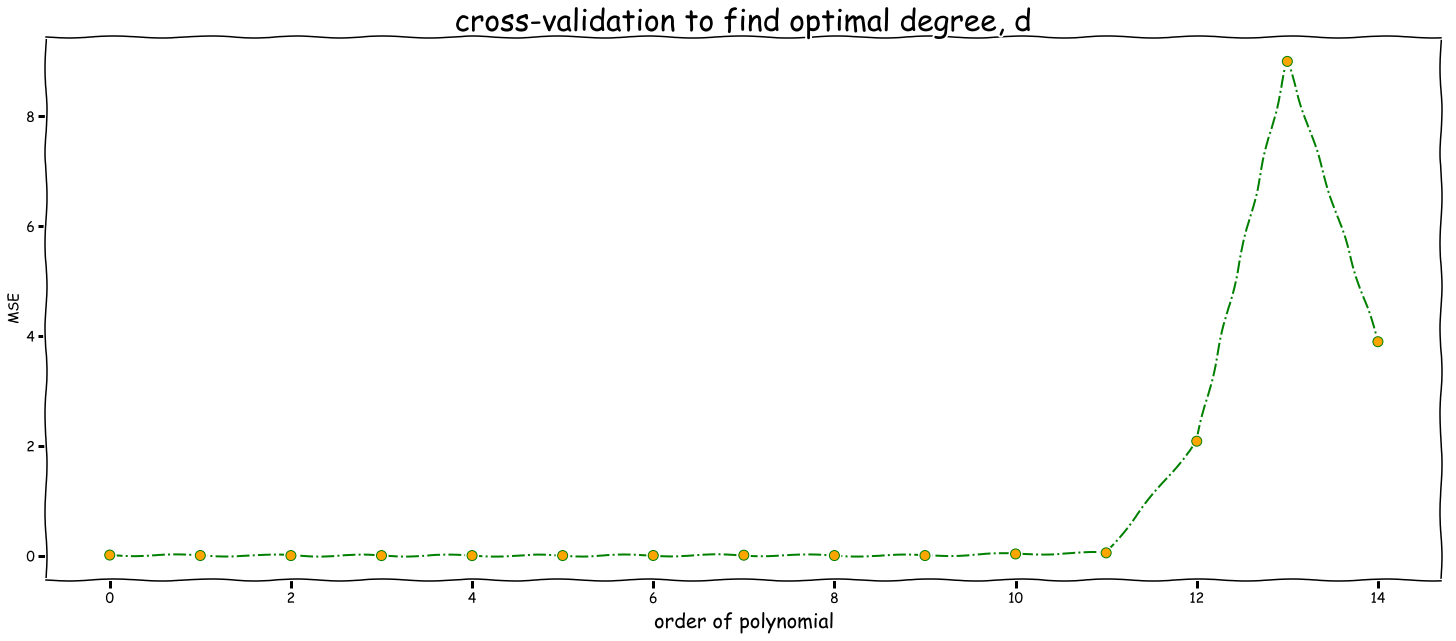

In [383]:
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('cross-validation to find optimal degree, d', fontsize=30)
plt.xlabel('order of polynomial', fontsize=20)
plt.ylabel('MSE')

**Cross-validation suggests $d$=3 to be give the smallest error and therefore is the optimal degree.**

Comparing it with $d$=4 and $d$=2

In [384]:
df = pd.concat([y, X, X**2, X**3, X**4], axis=1)
df.columns = ['nox', 'dis', 'dis^2', 'dis^3', 'dis^4']
lmfit2 = ols("df['nox']~df['dis']+df['dis^2']", data=df).fit()
lmfit3 = ols("df['nox']~df['dis']+df['dis^2']+df['dis^3']", data=df).fit()
lmfit4 = ols("df['nox']~df['dis']+df['dis^2']+df['dis^3']+df['dis^4']", data=df).fit()

In [386]:
anova_table = sm.stats.anova_lm(lmfit2, lmfit3, lmfit4, typ=1)
anova_table.index = anova_table.index+2
anova_table.round(2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,503.0,2.04,0.0,NaN,NaN,NaN
3,502.0,1.93,1.0,0.1,26.22,0.00
4,501.0,1.93,1.0,0.0,0.29,0.59


**I notice that at $d$=4, the $p$-value>5%. Therefore, it's not significant to have $d$>3.**

Text(0,0.5,'NOX')

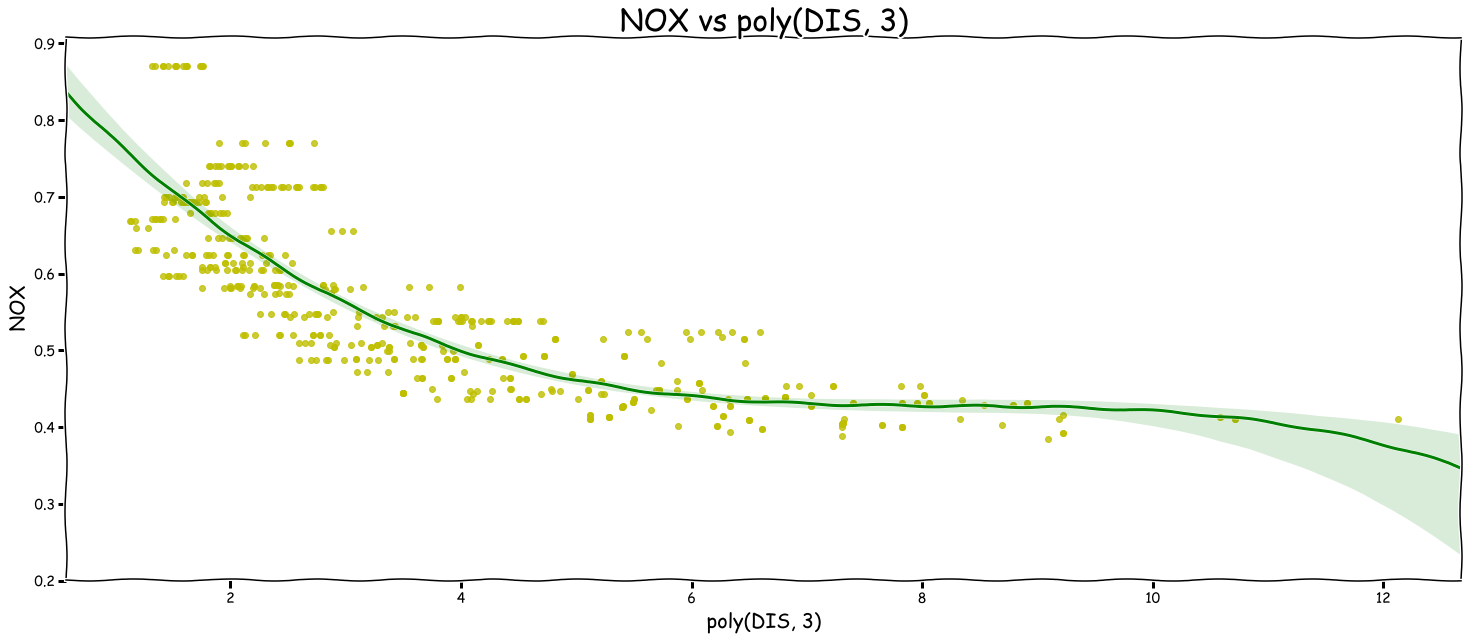

In [389]:
X1 = Boston['DIS']
X2 = X1**2
X3 = X1**3
plotdf = pd.concat([y, X1, X2, X3], axis=1)
plotdf.columns = ['NOX', 'DIS', 'DIS^2', 'DIS^3']
plt.xkcd()
plt.figure(figsize = (25, 10))
sns.regplot('DIS', 'NOX', data=plotdf, fit_reg=True, ci = 95, color='y', order=3, line_kws={'color':'green'})
plt.title('NOX vs poly(DIS, 3)', fontsize=30)
plt.xlabel('poly(DIS, 3)', fontsize=20)
plt.ylabel('NOX', fontsize=20)

In [390]:
lmfit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              df['nox']   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Thu, 24 Jan 2019   Prob (F-statistic):          2.71e-136
Time:                        21:02:56   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9341      0.021     45.110      0.000       0.893       0.975
df['dis']      -0.1821      0.015    -12.389      0.000      -0.211      -0.153
df['dis^2']     0.0219      0.003      7.476      0.000       0.016       0.028
df['dis^3']    -0.0009      0.000     -5.124      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       64.176   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.386
Skew:                           0.917   Prob(JB):                     1.06e-19
Kurtosis:                       3.886   Cond. No.                     2.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 9.b. Fitting polynomials from 1 to 10

In [391]:
X = Boston[['DIS']]
y = Boston['NOX']

n = len(X)

df = pd.DataFrame()
RSSdf = pd.DataFrame()

for k in range(0,21):
    X_k = X**k
    df = pd.concat([df, X_k], axis=1)
    df_a = np.array(df)
    lmk = LinearRegression().fit(df_a, y)
    err = pd.DataFrame([mean_squared_error(y, lmk.predict(df_a))*n]) # multiplying MSE by n gives RSS
    RSSdf = pd.concat([RSSdf, err], axis=0)

RSSdf.columns = ['RSS']
RSSdf.reset_index(drop=True, inplace=True)
RSSdf

,RSS
0,6.780956
1,2.768563
2,2.035262
3,1.934107
4,1.932981
5,1.915290
6,1.878257
7,1.849484
8,1.835630
9,1.833331


Text(0,0.5,'RSS')

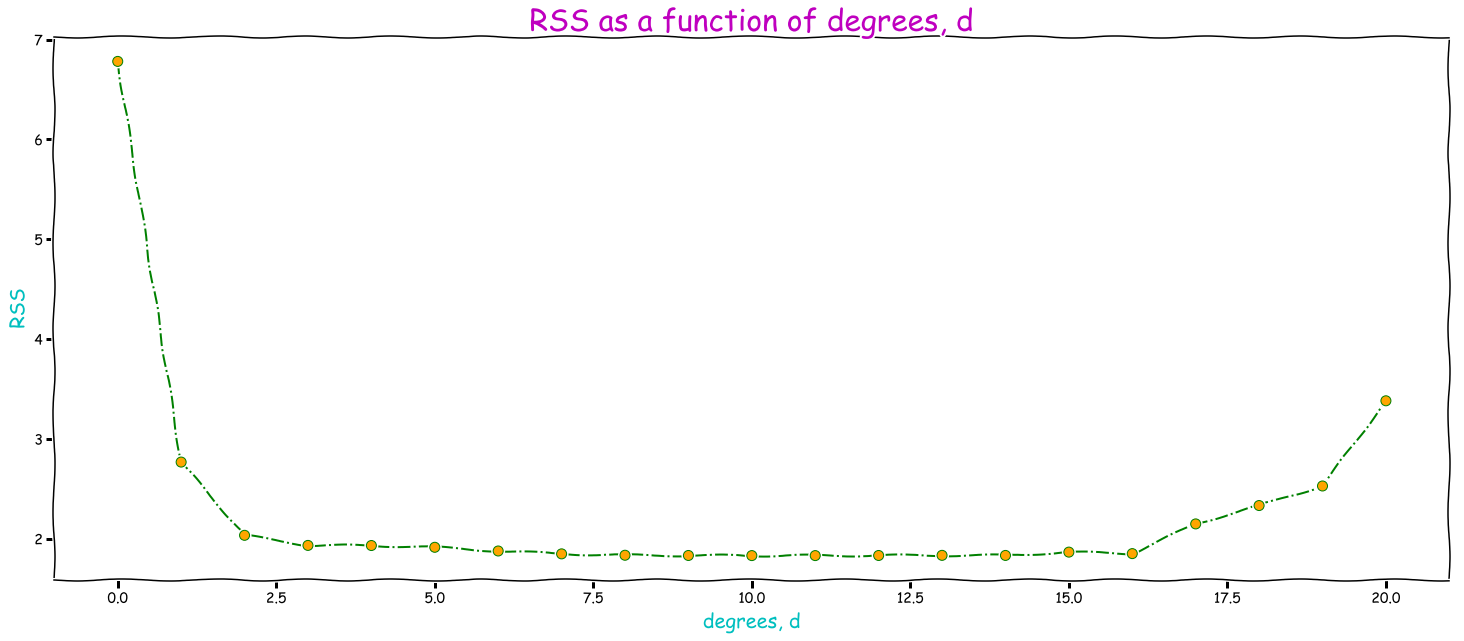

In [392]:
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(RSSdf, color='g', ls = '-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title("RSS as a function of degrees, d", fontsize=30, color='m')
plt.xlabel("degrees, d", fontsize=20, color='c')
plt.ylabel("RSS", fontsize=20, color='c')

**Without cross-validation, I get the lowest RSS at $d$=16. However, using such high-degree polynomial regression risks the model overfitting test results (I have achieved this RSS by predicting on the training data set).**

### 9.c. Cross-validation to find the optimal degree, $d$

*Already covered in 9.a.*

### 9.d. Fitting a regression spline to predict 'nox' using 'dis' (number of knots, $k$=4)

In [393]:
from patsy import dmatrix

Text(0.5,0,'dis')

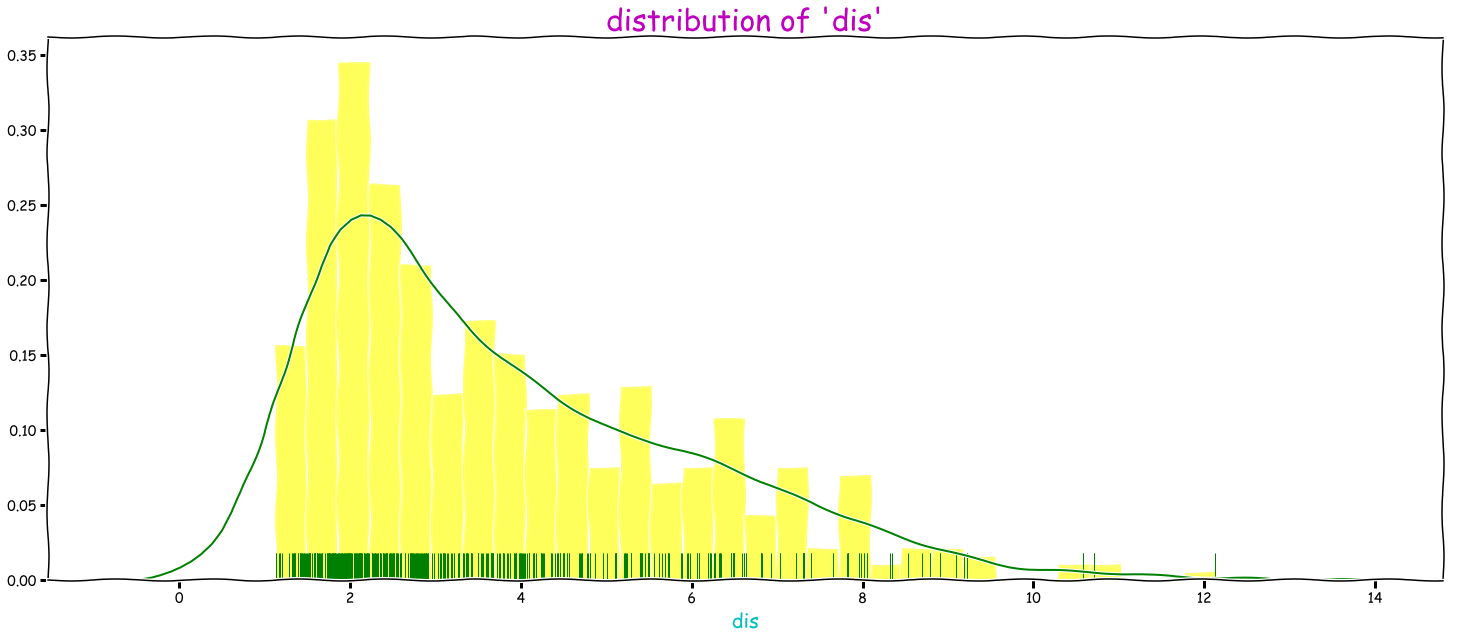

In [395]:
plt.xkcd()
plt.figure(figsize=(25, 10))
df = pd.concat([y, X], axis=1)
sns.distplot(X, color='g', bins=30, kde=True, rug=True, hist_kws={"color":"yellow"}, kde_kws={"color":"green"})
plt.title("distribution of 'dis'", fontsize=30, color='m')
plt.xlabel('dis', fontsize=20, color='c')

*I notice that NOX has the most significant change in distribution at 2 and is fairly smooth otherwise. So, I choose the knots at (2, 4, 6, 8)*

In [396]:
X1 = dmatrix("bs(DIS, knots=(2, 4, 6, 8), degree=3, include_intercept=False)", {"DIS": X}, return_type='dataframe')
y1 = y
df1 = pd.concat([y1, X1], axis=1)

In [397]:
lmfit1 = ols('y1~X1', data=df1).fit()
lmfit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y1   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     192.4
Date:                Thu, 24 Jan 2019   Prob (F-statistic):          3.23e-137
Time:                        21:03:08   Log-Likelihood:                 704.41
No. Observations:                 506   AIC:                            -1393.
Df Residuals:                     498   BIC:                            -1359.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3236      0.012     26.844      0.000       0.300       0.347
X1[0]          0.3236      0.012     26.844      0.000       0.300       0.347
X1[1]          0.1141      0.032      3.521      0.000       0.050       0.178
X1[2]         -0.0675      0.024     -2.770      0.006      -0.115      -0.020
X1[3]         -0.1686      0.030     -5.547      0.000      -0.228      -0.109
X1[4]         -0.1973      0.028     -7.147      0.000      -0.252      -0.143
X1[5]         -0.2437      0.041     -5.994      0.000      -0.324      -0.164
X1[6]         -0.2337      0.062     -3.754      0.000      -0.356      -0.111
X1[7]         -0.2374      0.063     -3.740      0.000      -0.362      -0.113
==============================================================================
Omnibus:                       66.946   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.016
Skew:                           0.934   Prob(JB):                     6.34e-21
Kurtosis:                       3.959   Cond. No.                     3.73e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.03e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [398]:
lmfit1_skl = LinearRegression().fit(X1, y1)
DISgrid = np.arange(Boston.DIS.min(), Boston.DIS.max()).reshape(-1,1)
Xpred1 = dmatrix("bs(DISgrid, knots=(2, 4, 6, 8), include_intercept=False)", {"DISgrid": DISgrid}, return_type='dataframe')
lmpred1 = lmfit1_skl.predict(Xpred1)

Text(0.5,1,'spline predictions for NOX vs DIS')

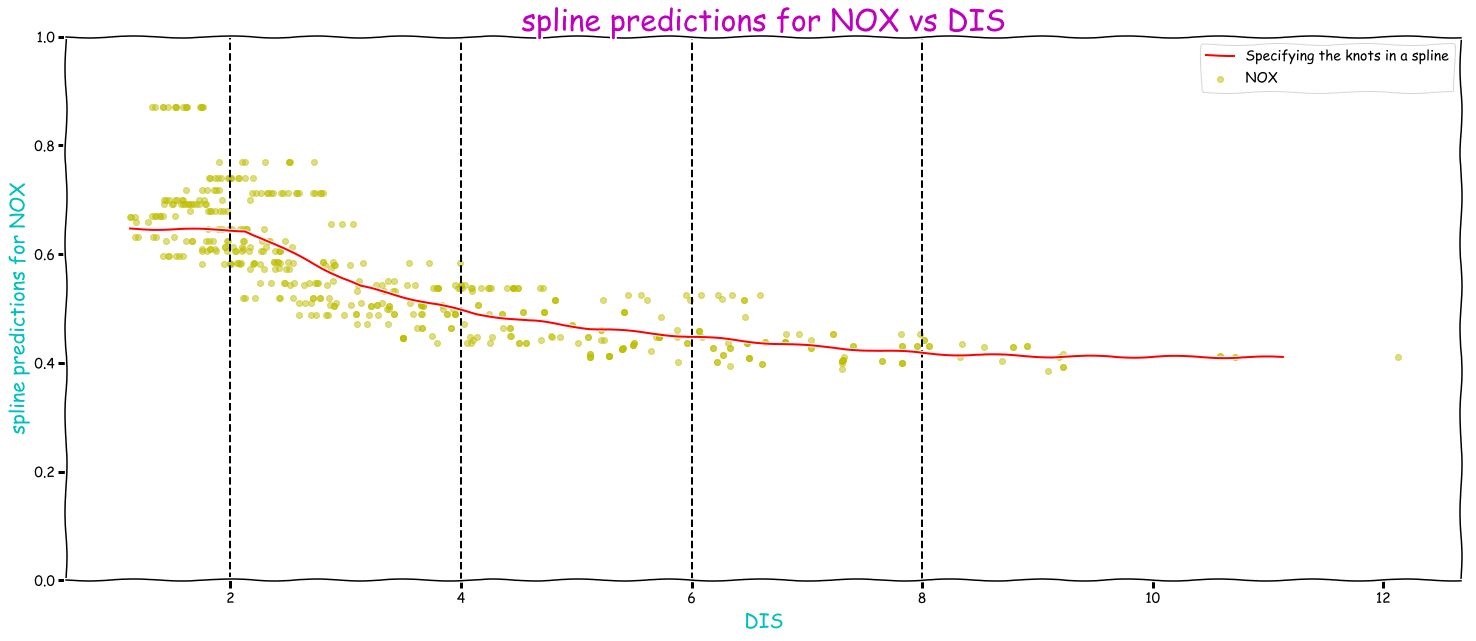

In [399]:
# plotting all predictions
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.scatter(X, y, facecolor='y', alpha=0.5)
plt.plot(DISgrid, lmpred1, color='r', label='Specifying the knots in a spline')
[plt.vlines(i , 0, 12, linestyles='dashed', lw=2, colors='k') for i in [2, 4, 6, 8]]
plt.legend()
plt.ylim(ymin=0,ymax=1)
plt.xlabel('DIS', fontsize=20, color='c')
plt.ylabel('spline predictions for NOX', fontsize=20, color='c')
plt.title('spline predictions for NOX vs DIS', fontsize=30, color='m')

### 9.e. Fitting a regression spline for a range of degrees of freedom

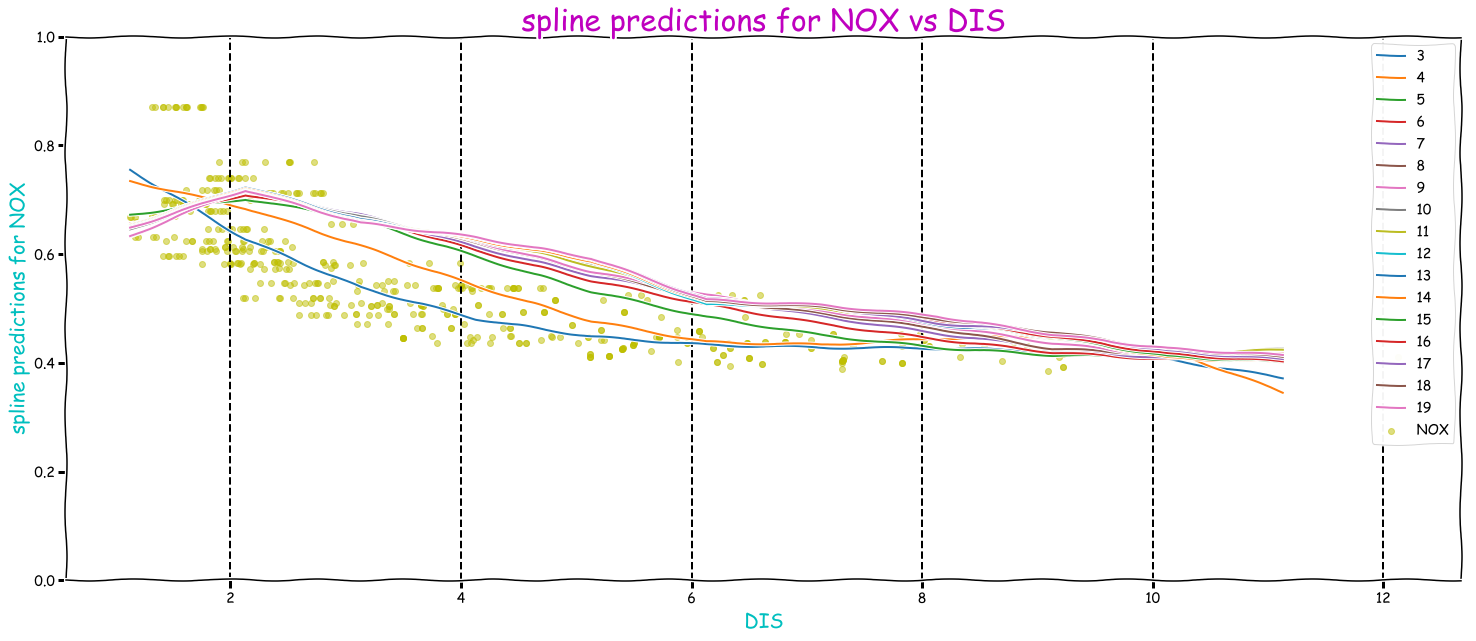

In [425]:
X = Boston[['DIS']]
y = Boston['NOX']
MSEdf = pd.DataFrame()
r2df = pd.DataFrame()

plt.xkcd()
plt.figure(figsize=(25, 10))
plt.scatter(X, y, facecolor='y', alpha=0.5)
[plt.vlines(i , 0, 12, linestyles='dashed', lw=2, colors='k') for i in [2, 4, 6, 8, 10, 12]]
plt.ylim(ymin=0,ymax=1)
plt.xlabel('DIS', fontsize=20, color='c')
plt.ylabel('spline predictions for NOX', fontsize=20, color='c')
plt.title('spline predictions for NOX vs DIS', fontsize=30, color='m')
for k in range(3,20):
    Xk = dmatrix("bs(DIS, df=k)", {"DIS": X}, return_type='dataframe')
    yk = y
    dfX = pd.concat([yk, Xk], axis=1)
    lmfit_skl = LinearRegression().fit(Xk, yk)
    Xpredk = dmatrix("bs(DISgrid, df=k)", {"DISgrid": DISgrid}, return_type='dataframe')
    lmpredk = lmfit_skl.predict(Xpredk)
    lmpredk1 = lmfit_skl.predict(Xk)
    err = pd.DataFrame([mean_squared_error(y, lmpredk1)])
    MSEdf = MSEdf.append(err)
    r2 = pd.DataFrame([r2_score(y, lmpredk1)])
    r2df = r2df.append(r2)
    plt.plot(DISgrid, lmpredk, label=k)
    plt.legend()
    
MSEdf.columns = ['MSE']
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.index = MSEdf.index+3

r2df.columns = ['MSE']
r2df.reset_index(drop=True, inplace=True)
MSEdf.index = MSEdf.index+3

**I have plotted regression splines from degrees, $d$=3 to $d$=20. It's easy to see that the spline overfits the data in higher order.**

Text(0.5,1,'R^2 for degrees of DIS')

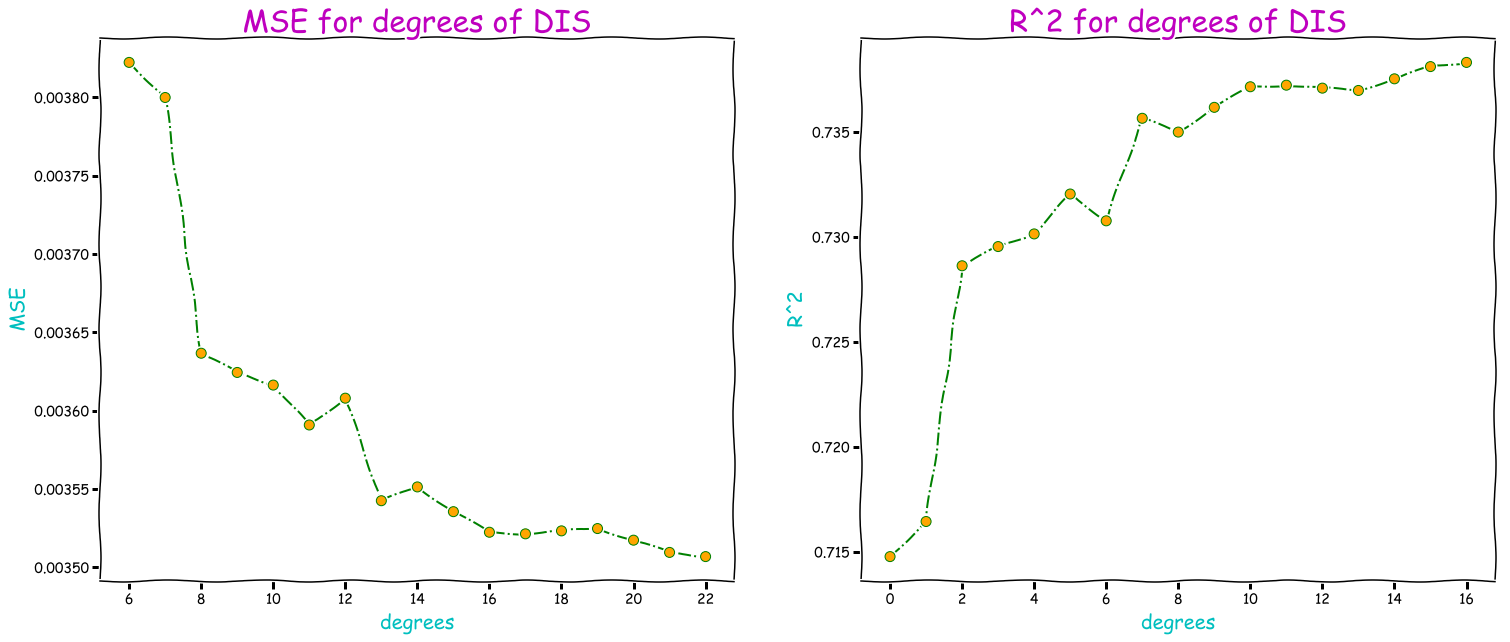

In [436]:
plt.xkcd()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))

ax1.plot(MSEdf, ls='-.', color='g', marker='o', markersize=10, markerfacecolor='orange')
ax1.set_xlabel('degrees', fontsize=20, color='c')
ax1.set_ylabel('MSE', fontsize=20, color='c')
ax1.set_title('MSE for degrees of DIS', color='m', fontsize=30)

ax2.plot(r2df, ls='-.', color='g', marker='o', markersize=10, markerfacecolor='orange')
ax2.set_xlabel('degrees', fontsize=20, color='c')
ax2.set_ylabel('R^2', fontsize=20, color='c')
ax2.set_title('R^2 for degrees of DIS', color='m', fontsize=30)

**The MSE decreases monotonically and then the rate of decrease slows down near $d$=20. Likewise, the $R^2$ increases monotonically and then the rate of increase slows down near $d$=20**

### 9.f. Performing cross-validation to select best degrees of freedom for a regression spline on this data

In [454]:
from sklearn.pipeline import make_pipeline
X = Boston.DIS.values.reshape(-1, 1)
y = Boston.DIS.values

In [461]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

lm = LinearRegression()
MSEdf= pd.DataFrame()
Xk = pd.DataFrame()

# calculating MSE for 15 degrees through cross-validation
for k in np.arange(3, 35):
    Xk = dmatrix("bs(DIS, df=k)", {"DIS": X}, return_type='dataframe')
    mse = -1*CVS(lm, Xk.iloc[:,:k], y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf.index = MSEdf.index + 3
MSEdf

,MSE
3,0.462010
4,0.478353
5,0.373179
6,0.366950
7,0.342336
8,0.337267
9,0.327705
10,0.324817
11,0.321905
12,0.319738


Text(0,0.5,'MSE')

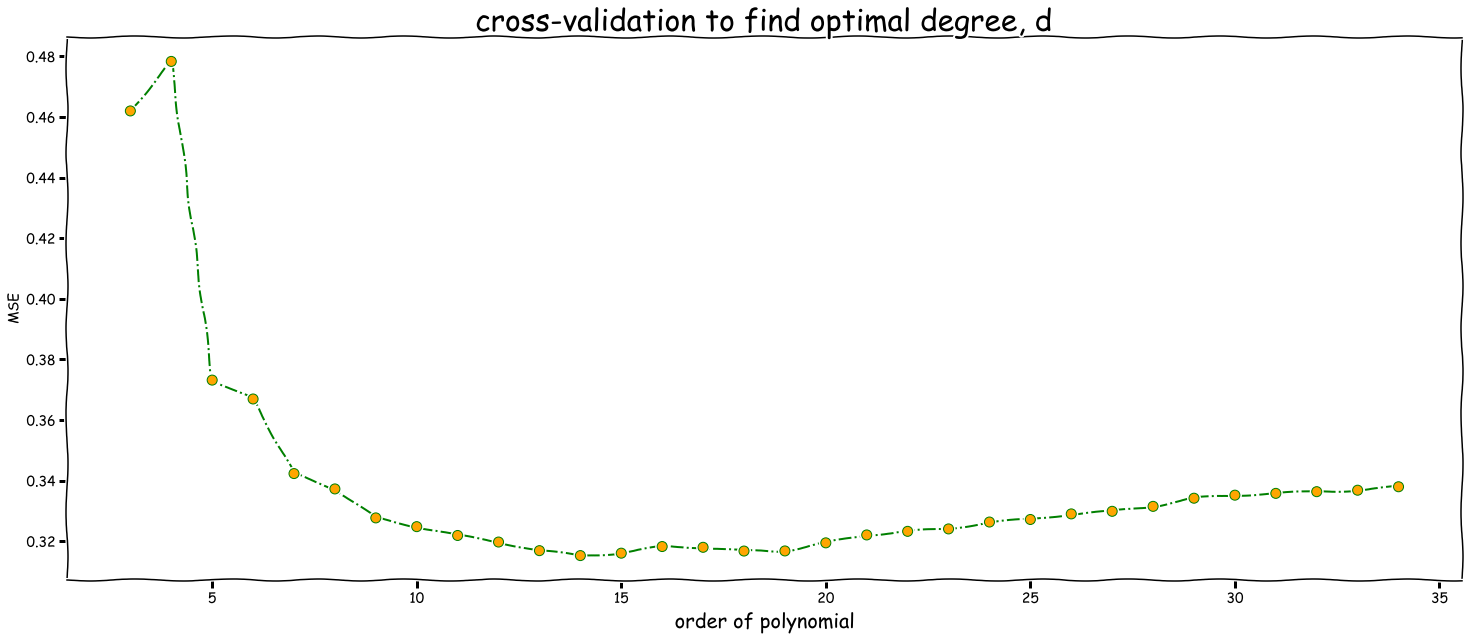

In [462]:
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('cross-validation to find optimal degree, d', fontsize=30)
plt.xlabel('order of polynomial', fontsize=20)
plt.ylabel('MSE')

**The lowest MSE occurs at $d$=14 and then increases over increasing degrees. Therefore, $d$=10 is the optimal degrees of freedom.**